## Infinite Impulse Response (IIR) Filters

[Infinite impulse response (IIR)](#ref1) is a property applying to many linear time-invariant systems that are distinguished by having an impulse response which does not become exactly zero past a certain point, but continues indefinitely. 

Digital filters are often described and implemented in terms of the difference equation that defines how the output signal is related to the input signal.

$$
\begin{gather} \tag{1.1}
    \begin{aligned}
    y[n] &= 1/a_0(b_0x[n] + b_1x[n-1] + ... + b_P x[n-P] \\
    &= - a_1y[n-1] - a_2y[n-2] - ... - a_Q y[n-Q]) \\
    \end{aligned}
\end{gather}
$$

where $y$ is the measurable scalar output, $x$ the measurable scalar input, $a_i$ are the feedforward filter coefficients, $b_j$ are the feedback filter coefficients, $P$ is the feedforward filter order, and $Q$ is the feedback filter order.

With the help of the Z-transform we are able to find a closed form solution to the transfer function.

$$
 \begin{gather} \tag{1.2}
    \begin{aligned}
        H(z) = \frac{Y(z)}{X(z)} = \frac{\sum_{i=0}^{P} b_jz^{-i}}{\sum_{j=0}^{Q} a_iz^{-j}}
    \end{aligned}
\end{gather}
$$

In [14]:
def sample_poles(filter_order):
    """
    Systems represented by stable right-sided sequences have all poles located within the unit circle, which suggests all eigenvalues of the system have magnitude less than one and thus state variables decay over time.
    """
    centerX = centerY = 0
    R = 1
    z = [0] * filter_order
    p = []
    for _ in range(filter_order // 2):
        r = R * np.sqrt(np.random.rand())
        theta = np.random.rand() * 2 * np.pi
        x = centerX + r * np.cos(theta)
        y = centerY + r * np.sin(theta)
        t = x + y * 1j

        p.append(t)
        p.append(t.conjugate())

    if filter_order%2 == 1:
        p.append(np.random.rand())
    return z, p

def sample_real_poles(N):
    centerX = centerY = 0
    R = 1

    z = [0] * N
    p = []
    for i in range(N):
        p.append(np.random.rand())

    return z, p

def create_gaussian_signal(seq_len, b, a):
    """
    Filter gaussian noise throught the IIR filter designed via Pole-sampling
    """
    xn = np.random.normal(0, 1, size=seq_len)
    x = signal.lfilter(b, a, xn)
    return xn, x

# Create input and output of shape (batch_size x seq_len x input_dims) 
def create_dataset(batch_size, seq_len, b, a):

    X = []
    Y = []
    for _ in range(batch_size):
        xn, x = create_gaussian_signal(seq_len, b, a)
        X.append(xn)
        Y.append(x)
            
    X = np.array(X)
    X = np.swapaxes(X, 0, 1)
    X = np.expand_dims(X, axis=2)

    Y = np.array(Y)
    Y = np.swapaxes(Y, 0, 1)
    Y = np.expand_dims(Y, axis=2)

    return X, Y

Let us create an all-pole $3^{rd}$ IIR filter with a difference equation

$$\large  \tag{1.3}
y[t]=x[t]+a_1 \cdot y[t−1] + a_2 \cdot y[t−2] + a_3 \cdot y[t−3]$$

and resulting Z-transform of the transfer function:

$$
\begin{gather} \tag{1.4}
    \begin{aligned}
        H(z) &= \dfrac{1}  {1-a_1\cdot z^{-1}-a_2\cdot z^{-2}-a_3\cdot z^{-3}} \\
        &= \dfrac{1}  {(1-p_0\cdot z^{-1})(1-p_1\cdot z^{-1})(1-p_2\cdot z^{-1})} 
    \end{aligned}
\end{gather}
$$

The denominator polynomial is of order 3, and hence has 3 zeros, which result in 3 poles, $p_0$, $p_1$, and $p_2$ of the transfer function $H(z)$. Each pole causes an oscillation at a frequency given by its angle to the real axis, in radians. If we want a real valued oscillation, we need a conjugate complex pole pair. This can be extended to a filter of any order N.

In [15]:
import numpy as np
import scipy.signal as signal

# Set Parameters
filter_order = N = 5
hidden_size = 5

seq_len = 150
wash_out = 50
batch_size = 100
split_ratio = 0.8

# Generate Data
z, p = sample_poles(filter_order)
b, a = signal.zpk2tf(z, p, 1)
X, Y = create_dataset(batch_size, seq_len, b, a)

split_index = int(split_ratio*batch_size)
train_X, train_Y = X[:,:split_index,:], Y[:,:split_index,:]
test_X, test_Y = X[:,split_index:,:], Y[:,split_index:,:]

In [16]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

%matplotlib inline

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'

In [17]:
def stylize_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis="x", direction="in")
    ax.tick_params(axis="y", direction="in")

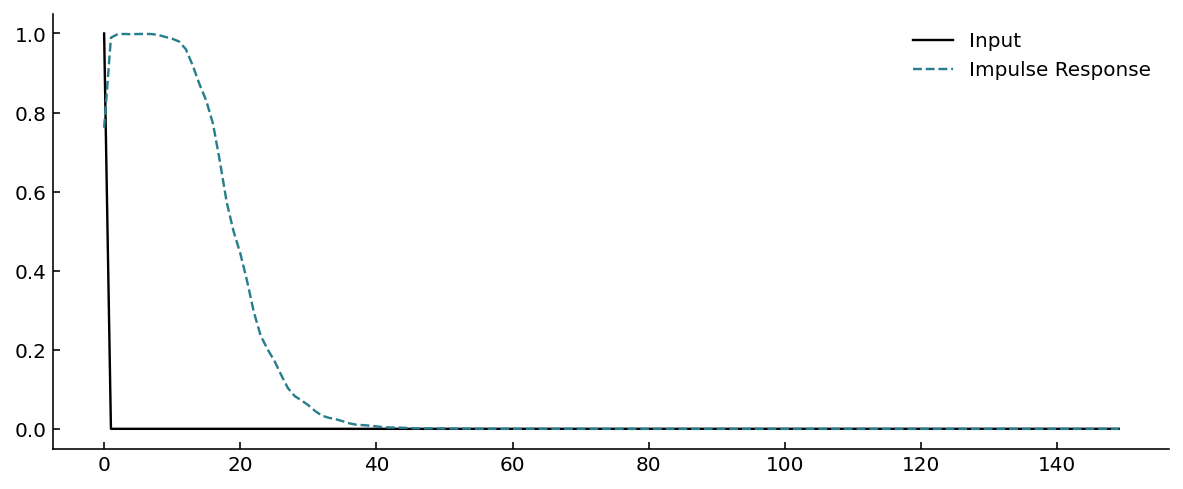

In [18]:
input = signal.unit_impulse(seq_len)
output = np.tanh(signal.lfilter(b, a, input))

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
stylize_axes(ax)
ax.plot(input, label="Input", color="black", linewidth=1.2)
ax.plot(output, label="Impulse Response", color=sns.color_palette("viridis")[2], linestyle="--", linewidth=1.2)
ax.legend(loc="upper right", frameon=False)
plt.show()

## Linear Recurrent Neural Networks (RNNs)
RNNs compute an internal "state" from the input, which then becomes part of the input in the next time-step. In an RNN instead we have the "hidden states" *h*, which is a vector or array which is updated after each sample interval according to the matrix equation:

$$\large \tag{1.6}
h_t=tanh(W_{ih}\cdot  x_t+b_{ih}+W_{hh}\cdot h_{t−1}+b_{hh})$$

where $x_t$ is our input signal (here the impulse), and *t* is our integer valued time index (which was *n* for the IIR filter). The *W* are weight matrices, and the *b* are the biases.

This makes it similar to linear IIR filters, which have a feedback path via delay elements from their output back to their input. To make it function like our *IIR filter*, we use the hidden states as the delay line in our IIR filter, which means the hidden states are equal to the filter output and its two delayed versions:

$$\large \tag{1.7}
h_t[i] = y[t−i] \text{ for i = 0, 1, 2...}$$

hence i=0 denotes the most recent sample.

From the time domain difference Eq 1.1 we know that:

$$\large \tag{1.8}
h_t[0]=y[t]=x[t]+a_1 \cdot y[t−1] + a_2 \cdot y[t−2] + a_3 \cdot y[t−3]$$

which equals:

$$\large \tag{1.9}
h_t[0] = x[t]+a_1 \cdot h_{t−1} [0] + a_2 \cdot h_{t−1} [1] + a_3 \cdot h_{t−3} [2] $$

Then we just need to shift the remaining hidden states by one time step down such that they become the delay line:

$$\large \tag{1.10}
h_t[1] = h_{t−1}[0] \\
\large
h_t [2] = h_{t−1}[1] \\
\large
h_t [3] = h_{t−1}[2] $$

These equations now give us the necessary weight matrices $W_{hh}$ and $W_{ih}$ , in our simplified RNN update equation:

$$\large \tag{1.11}
h_t=W_{ih} \cdot x_t+W_{hh} \cdot h_{t−1}$$

where we neglected the non-linear activation function and set the biases to zero.

In [19]:
import torch
from torch import nn

class RNNLayer(nn.Module):
    """Linear RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
                if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = self.i2h(input) + self.h2h(hidden)
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        self.rnn = RNNLayer(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

Mapping the network structure, we get

$$\large \tag{1.12}
W_{ih}=
\begin{bmatrix}
 1\\
0 \\
0
\end{bmatrix}$$

$$\large \tag{1.13}
W_{hh}=
\begin{bmatrix}
a_1 & a_2 & a_3\\
1 & 0 & 0 \\
0 & 1 & 0
\end{bmatrix}$$

The output of our RNN is $h_t[0]$ , which we obtain by adding a linear output layer, which has a factor of 1 for this element, and zeros for the other elements.

$$\large \tag{1.14}
W_{ho}=
\begin{bmatrix}
 1 & 0 & 0
\end{bmatrix}$$

In [20]:
# Instantiate Model
net = RNNNet(1, N, 1)

# Shifted diagonal matrix and IIR filter coefficients
a_copy = -a
a_copy[0] = 1
h2h = torch.diag(torch.ones(N-1), diagonal=-1)
h2h[0,:] = torch.from_numpy(a_copy[1:])
net.rnn.h2h.weight = nn.Parameter(h2h)

# Vector with a "1" for input x
i2h = torch.zeros((N,1))
i2h[0,0] = torch.tensor(1.0)
net.rnn.i2h.weight = nn.Parameter(i2h)

# Weight for linear output layer to select h[0]
fc = torch.zeros((1,N))
fc[0][0] = torch.tensor(1.0)
net.fc.weight = nn.Parameter(fc)

# Predict
test_inp = torch.from_numpy(test_X).type(torch.float)
test_out = torch.from_numpy(test_Y).type(torch.float)
pred, rnn_output = net(test_inp)

# Compute Loss
criterion = nn.MSELoss()
loss_optimal = criterion(pred[wash_out:,:,:], test_out[wash_out:,:,:]).detach().numpy()
print(loss_optimal)

1.7009338e-09


In [21]:
import cmath
import matplotlib.pyplot as plt

def extract_eigen_values(M):
    eW = np.linalg.eigvals(M)
    rea = [n.real for n in eW]
    imag = [n.imag for n in eW]
    return rea, imag

def polar_plot(real_poles, imag_poles, realW_bptt, imagW_bptt, realW_filter=[], imagW_filter=[]):
    fig = plt.figure(figsize=(12,12))

    theta, r = [], []
    for i,j in zip(real_poles, imag_poles):
        r_c, theta_c = cmath.polar(complex(i, j))
        r.append(r_c)
        theta.append(theta_c)

    r_bptt, theta_bptt = [], []
    for i,j in zip(realW_bptt, imagW_bptt):
        r_c, theta_c = cmath.polar(complex(i, j))
        r_bptt.append(r_c)
        theta_bptt.append(theta_c)
    
    if realW_filter is not None:
        r_filter, theta_filter = [], []
        for i,j in zip(realW_filter, imagW_filter):
            r_c, theta_c = cmath.polar(complex(i, j))
            r_filter.append(r_c)
            theta_filter.append(theta_c)

    ax = fig.add_subplot(121, projection='polar')
    ax.scatter(theta, r, color='black', marker='x', label='Poles')
    ax.scatter(theta_bptt, r_bptt, color='red', marker='.', label='RNN Eigenvalues')
    if realW_filter is not None:
        ax.scatter(theta_filter, r_filter, color='blue', marker='.', label='Filter Eigenvalues')
    ax.set_rmax(1)
    ax.set_rticks([0.25, 0.5, 0.75, 1])    # Less radial ticks
    ax.set_rlabel_position(-22.5)          # Move radial labels away from plotted line
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.2, -0.05), loc="center right", frameon=False)
    plt.show()  

## Visualize the Poles
The z plane is a unit circle that describes a surface of complex numbers using polar coordinates. Poles and zeros are the roots of the denominator and numerator polynomials, respectively.

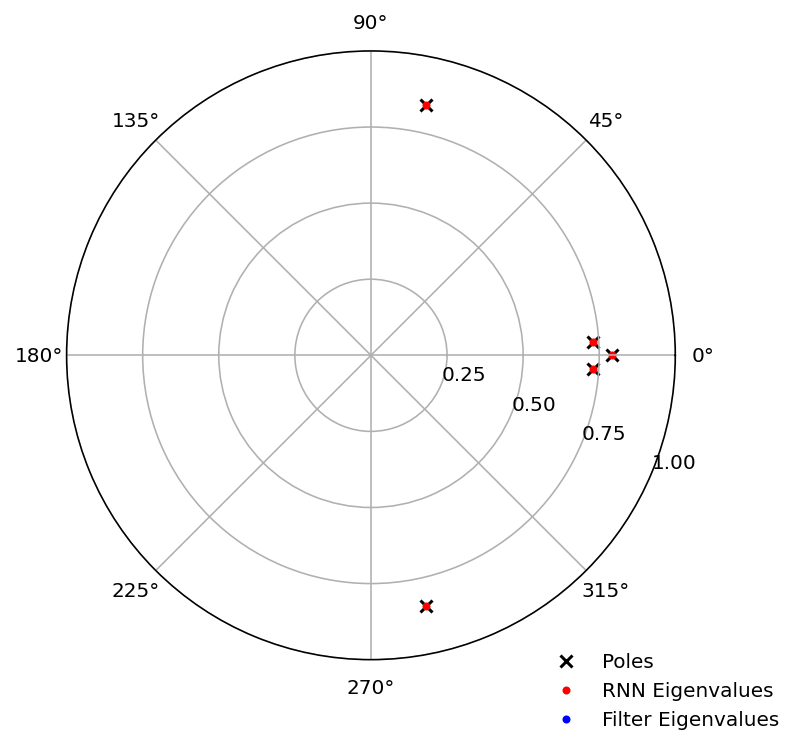

In [22]:
real_poles, imag_poles = [x.real for x in p], [x.imag for x in p]
realW_bptt, imagW_bptt = extract_eigen_values(net.rnn.h2h.weight.detach().numpy())
polar_plot(real_poles, imag_poles, realW_bptt, imagW_bptt)

## Train an RNN
#### What is the relationship between poles of a filter and eigenvalues of a feedback system?
In linear and linearizable networks, a system with feedback loops is fully characterized by its poles, which can be realized as the eigenvalues of the weight matrix of a linear neural network. 

For instance, a feedback loop system with a delay of two and feedback weight $w_1$, $w_2$, $w_3$ with its corresponding transfer function $H(z)$ (left) can be implemented as a cycle of length 3 with weights $w_1$, $w_2$, $w_3$ characterized by its eigenvalues $\lambda$ (right) and the poles of the transfer function are given by the eigenvalues of the adjacency matrix (center).

<img src="figures/state-space.png" width="700">

As multiple weight matrices can implement the same dynamics by having identical eigenvalues, we can train an RNN from scratch to emulate the filter and compare teacher and student networks not by their network structure but by their eigenvalues representing the primary modes of activity.

In [23]:
import sys 

def findClosestPair(real_pole, imag_pole, W_bptt_set):
    min_euclidean_dist = sys.maxsize
    closest_pair = W_bptt_set[0]
    a = np.array((real_pole ,imag_pole))
    for pair in W_bptt_set:
        b = np.array((pair[0], pair[1]))
        euclidean_dist = np.linalg.norm(a-b)
        if euclidean_dist < min_euclidean_dist:
            min_euclidean_dist = euclidean_dist
            closest_pair = pair
    return min_euclidean_dist, closest_pair

def compute_similarity(threshold, real_poles, imag_poles, realW_bptt, imagW_bptt):
    count = 0
    W_bptt_set = [[realW_bptt[i], imagW_bptt[i]] for i in range(len(realW_bptt))]
    for real_pole, imag_pole in zip(real_poles, imag_poles):
        min_euclidean_dist, closest_pair = findClosestPair(real_pole, imag_pole, W_bptt_set)
        if min_euclidean_dist <= threshold:
            count += 1
        W_bptt_set.remove(closest_pair)
    return count

In [24]:
net_trained = RNNNet(1, hidden_size, 1)

optimizer = torch.optim.Adam(net_trained.parameters(), lr=0.01)

loss_train = []
similarity = []

epochs = 3000
for epoch in range(epochs):
    # Zero the gradient buffer
    optimizer.zero_grad()
    
    # Forward pass
    train_inp = torch.from_numpy(train_X).type(torch.float)
    train_out = torch.from_numpy(train_Y).type(torch.float)
    pred, _ = net_trained(train_inp)

    # Measure the loss
    loss = criterion(pred[:,wash_out:,:], train_out[:,wash_out:,:])
    loss_train.append(loss.data.item())

    realW_bptt, imagW_bptt = extract_eigen_values(net_trained.rnn.h2h.weight.detach().numpy())

    count = 0
    W_bptt_set = [[realW_bptt[i], imagW_bptt[i]] for i in range(len(realW_bptt))]
    for real_pole, imag_pole in zip(real_poles, imag_poles):
        min_euclidean_dist, closest_pair = findClosestPair(real_pole, imag_pole, W_bptt_set)
        count += min_euclidean_dist
        W_bptt_set.remove(closest_pair)

    similarity.append(count/len(real_poles))

    # Print the loss
    if epoch%50==0:
        print(epoch, loss.data.item())

    # Backward pass
    loss.backward()
    optimizer.step()

0 110.79505920410156
50 99.2960205078125
100 98.16181945800781
150 94.22566986083984
200 87.5894546508789
250 75.72798919677734
300 51.947845458984375
350 17.758407592773438
400 11.57214069366455
450 9.194961547851562
500 8.012838363647461
550 7.095235824584961
600 6.244341850280762
650 5.394314765930176
700 4.500301837921143
750 3.544600486755371
800 2.5620086193084717
850 1.6572932004928589
900 0.9696973562240601
950 0.5672911405563354
1000 0.3878094255924225
1050 0.32113781571388245
1100 0.29711252450942993
1150 0.2878429591655731
1200 0.2840003967285156
1250 0.28229862451553345
1300 0.2814541757106781
1350 0.2809443771839142
1400 0.280558317899704
1450 0.2802138328552246
1500 0.2798800468444824
1550 0.2795456647872925
1600 0.27920669317245483
1650 0.27886176109313965
1700 0.2785102427005768
1750 0.2781519591808319
1800 0.27778658270835876
1850 0.2774139940738678
1900 0.27703389525413513
1950 0.27664613723754883
2000 0.276250422000885
2050 0.2758465111255646
2100 0.2754342555999756


In [25]:
def plot_loss_history(loss_train, loss_test, loss_optimal):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.loglog(loss_train, color='blue', label ="BPTT Train")
    ax.loglog(loss_test*np.ones(epochs), color='gray', label ="BPTT Test")
    ax.loglog(loss_optimal*np.ones(epochs), color='black', label ="Optimal")
    stylize_axes(ax)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    plt.legend()
    ax.legend(loc="upper right", frameon=False)
    plt.show()

0.28834796


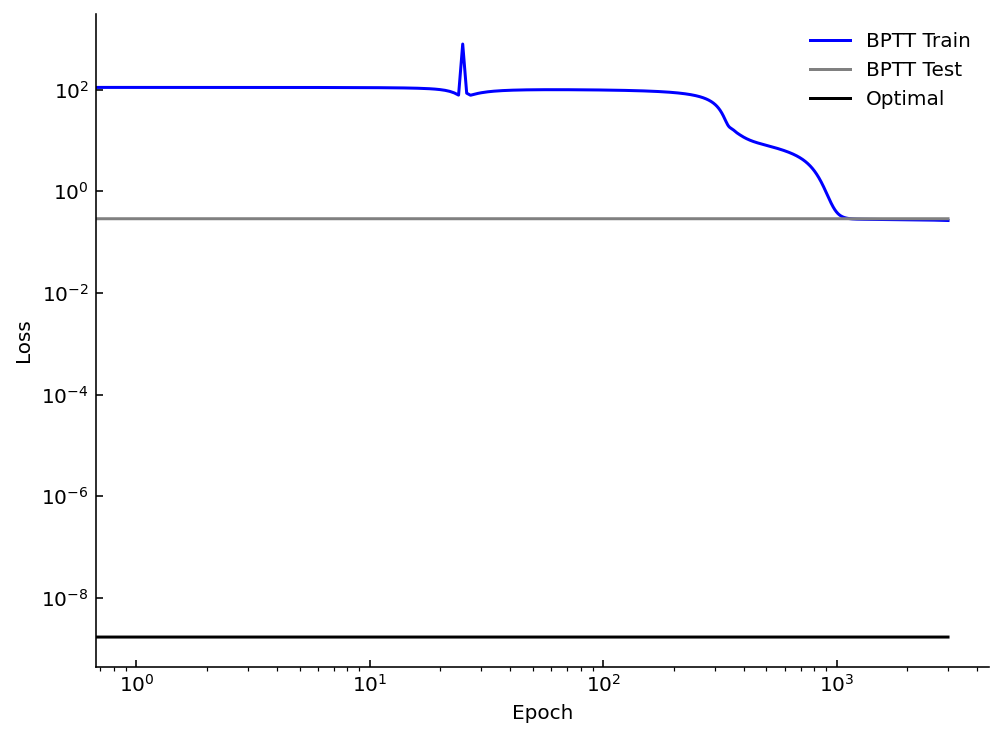

In [26]:
# Predict
test_inp = torch.from_numpy(test_X).type(torch.float)
test_out = torch.from_numpy(test_Y).type(torch.float)
pred, rnn_activity = net_trained(test_inp)

# Compute Loss
criterion = nn.MSELoss()
loss_test = criterion(pred[wash_out:,:,:], test_out[wash_out:,:,:]).detach().numpy()
print(loss_test)

plot_loss_history(loss_train, loss_test, loss_optimal)

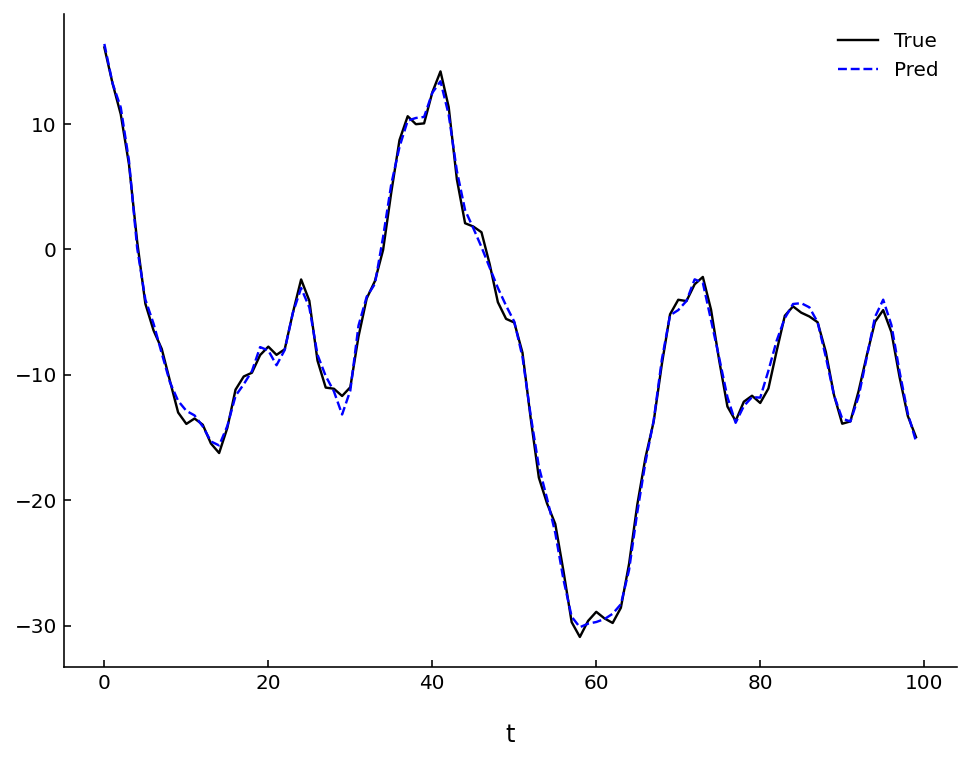

In [27]:
def plot_time_series(true, pred):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    stylize_axes(ax)
    ax.plot(true, label="True", linestyle='solid', color='black', linewidth=1.2)
    ax.plot(pred, label="Pred", linestyle='dashed', color='blue', linewidth=1.2)
    ax.set_xlabel("t", fontsize=12, labelpad=15)
    ax.legend(loc="upper right", frameon=False)
    plt.show()

index_to_plot = 0
plot_time_series(test_out[wash_out:,index_to_plot,0].detach().numpy(), pred[wash_out:,index_to_plot,0].detach().numpy())

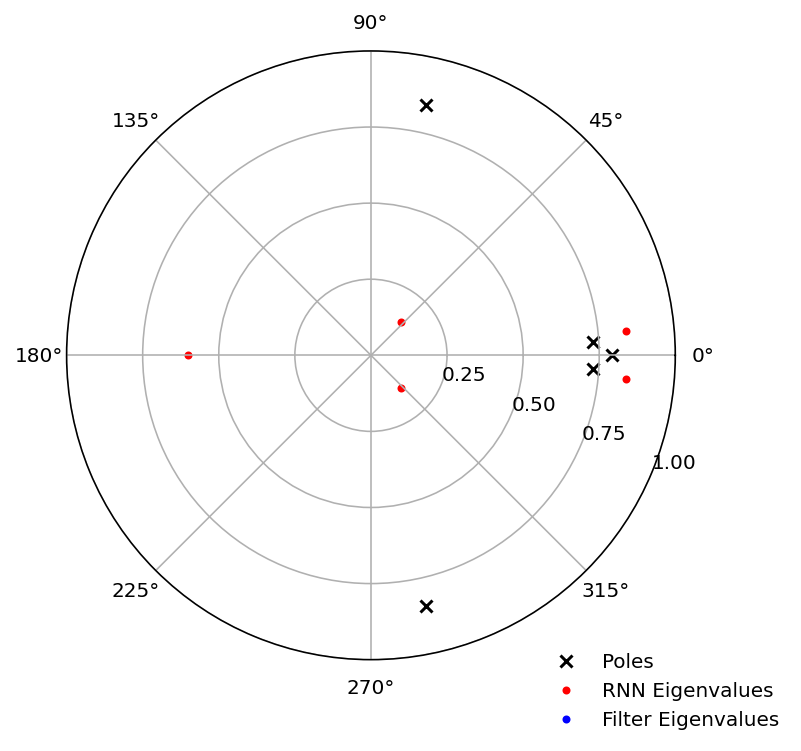

In [28]:
realW_bptt, imagW_bptt = extract_eigen_values(net_trained.rnn.h2h.weight.detach().numpy())
polar_plot(real_poles, imag_poles, realW_bptt, imagW_bptt)

In [29]:
overlaps_005 = compute_similarity(0.05, real_poles, imag_poles, realW_bptt, imagW_bptt)
print(overlaps_005)

0


# Supplementary Material

## Visualize the neural activity for sample trials

We will run the network for 100 sample trials, then visual the neural activity trajectories in a PCA space.

In [30]:
activity_dict = {}
trial_infos = {}

num_trial = 100
for i in range(num_trial):
    xn, _ = create_gaussian_signal(seq_len, b, a)
    inputs = torch.from_numpy(xn[:, np.newaxis, np.newaxis]).type(torch.float)
    action_pred, rnn_activity = net_trained(inputs)
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    
# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

Shape of the neural activity: (Time points, Neurons):  (15000, 5)


In [31]:
# Compute PCA and visualize
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(rnn_activity)

PCA(n_components=2)

Text(0, 0.5, 'PC 2')

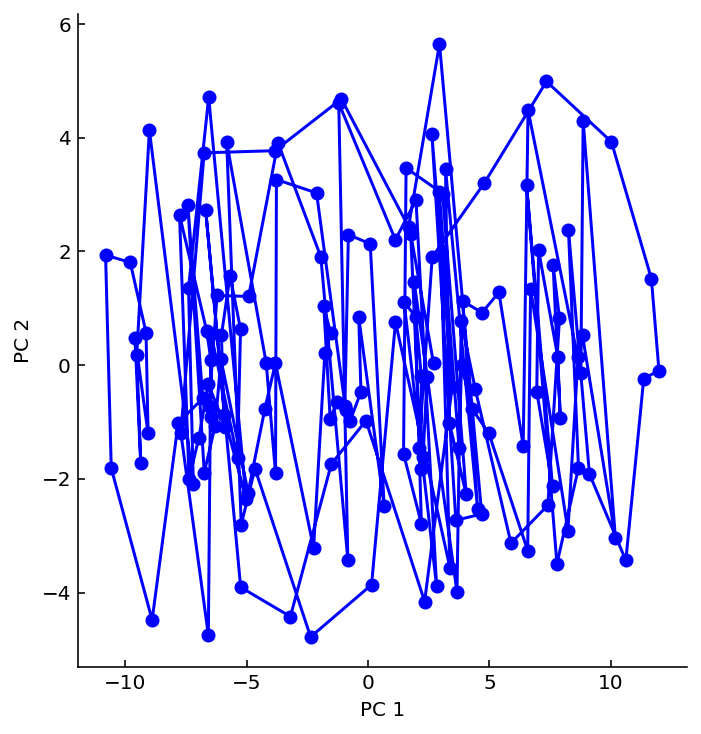

In [32]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
stylize_axes(ax)
for i in range(1):
    activity_pc = pca.transform(rnn_activity)
    _ = ax.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color='blue')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

## Dynamical System Analysis

### Search for approximate fixed points
Here we search for [approximate fixed points](#ref2). In a generic dynamical system,
\begin{align}  \tag{2.1}
    \frac{d\mathbf{x}}{dt} = F(\mathbf{x}),
\end{align}
We can search for fixed points by doing the optimization
\begin{align}  \tag{2.2}
    \mathrm{argmin}_{\mathbf{x}} |F(\mathbf{x})|^2.
\end{align}

In [33]:
# Freeze for parameters in the recurrent network
for param in net_trained.parameters():
    param.requires_grad = False

batch_size = 64
input = np.tile([0.5], (batch_size, 1))
input = torch.tensor(input, dtype=torch.float)

# Here hidden activity is the variable to be optimized
# Initialized randomly for search in parallel (activity all positive)
hidden = torch.tensor(np.random.rand(batch_size, net_trained.rnn.hidden_size), requires_grad=True, dtype=torch.float)

running_loss = 0

optimizer = torch.optim.Adam([hidden], lr=0.001)
criterion = nn.MSELoss()

for epoch in range(10000):
    # Zero the gradient buffer
    optimizer.zero_grad()
    
    # Take the one-step recurrent function from the trained network
    new_h = net_trained.rnn.recurrence(input, hidden)

    # Measure the loss
    loss = criterion(new_h, hidden)

    # Print the loss
    if epoch%1000 == 0:
        print(epoch, loss.data.item())

    # Backward pass
    loss.backward()
    optimizer.step()

0 0.5957533121109009
1000 0.17357215285301208
2000 0.12350399792194366
3000 0.1033029556274414
4000 0.08269760757684708
5000 0.062494002282619476
6000 0.04454381763935089
7000 0.02981681562960148
8000 0.018524426966905594
9000 0.01045447401702404


### Visualize the found approximate fixed points

(64, 5)


Text(0, 0.5, 'PC 2')

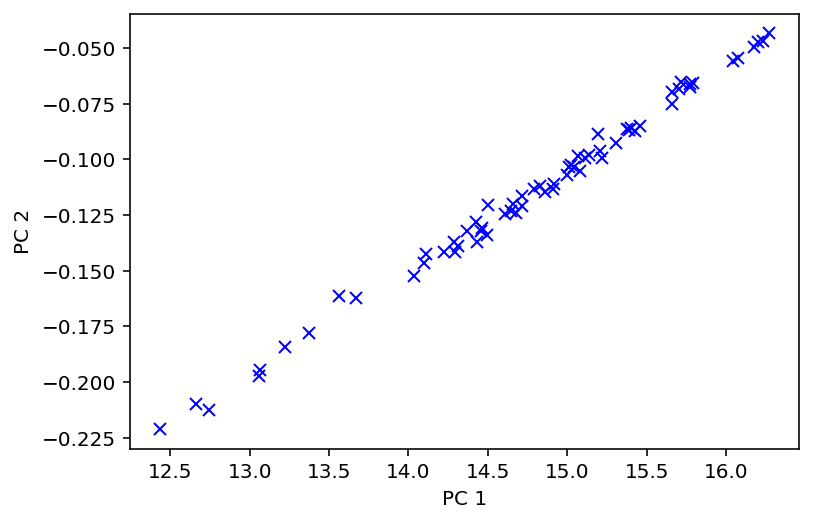

In [34]:
fixedpoints = hidden.detach().numpy()
print(fixedpoints.shape)

# Compute PCA and visualize
from sklearn.decomposition import PCA

# Plot in the same space as activity
plt.figure()
for i in range(5):
    activity_pc = pca.transform(activity_dict[i])
    _ = ax.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color='blue')

# Fixed points are shown in cross
fixedpoints_pc = pca.transform(fixedpoints)
plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x', color='blue')

plt.xlabel('PC 1')
plt.ylabel('PC 2')

# References

<a id="ref1"> </a> [1] https://en.wikipedia.org/wiki/Infinite_impulse_response

<a id="ref2"> </a> [2] David Sussillo, Omri Barak; Opening the Black Box: Low-Dimensional Dynamics in High-Dimensional Recurrent Neural Networks. Neural Comput 2013; 25 (3): 626–649. doi: https://doi.org/10.1162/NECO_a_00409